# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

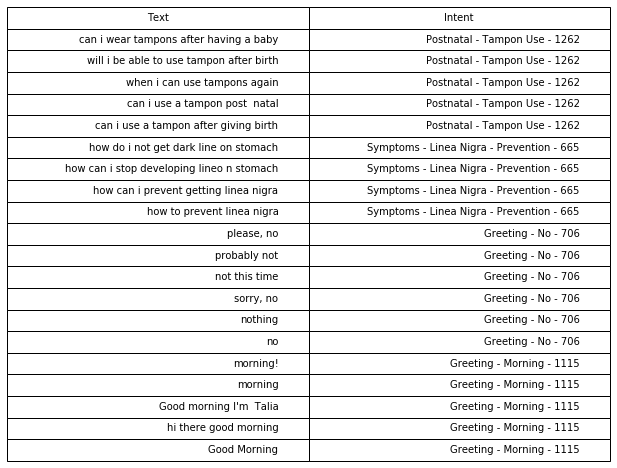

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

Start training the classification model and save

In [7]:
from fasttext_utils import _process_sentences

X_train_words, X_train_ngrams = _process_sentences(X_train)

print(X_train_words.shape)

(10256, 50, 300)


In [11]:
X_train_ngrams.shape

(10256, 50)

In [8]:
num_classes = len(classes)
ident_matrix = np.eye(num_classes)
y_train = np.array([ident_matrix[int(y)] for y in y_train])

In [9]:
from keras.layers import Embedding, Dense, TimeDistributed, Input, Masking
from keras.models import Model
from keras import backend as K
from config import SENTENCE_DIM, EMBEDDING_DIM, NGRAM_BINS

def build_model():
    model = Model()
    
    words_input = Input(shape=(SENTENCE_DIM, EMBEDDING_DIM))
#     words_embs = Masking()(words_input)
    words_embs = TimeDistributed(Dense(EMBEDDING_DIM))(words_embs)
    
    ngram_input = Input(shape=(SENTENCE_DIM,))
    ngram_embs = Embedding(NGRAM_BINS, EMBEDDING_DIM, input_length=SENTENCE_DIM, trainable=False)(ngram_embs)
    ngram_embs = TimeDistributed(Dense(EMBEDDING_DIM))(ngram_embs)
    
    

/Users/2359media/anaconda/envs/botbot-nlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Plot the losses graph (this helps choosing number of epochs and learning rate)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

losses = [loss for loss in losses if loss < 1.2]

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=5)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

NameError: name 'losses' is not defined

Test the trained model

In [ ]:
from text_classification.fast_text.predict import predict
import torch.nn.functional as F

TEST_SENTENCE = 'can i wear tampons'

with torch.no_grad():
    model.eval()
    scores = model([TEST_SENTENCE])
    print(scores.size())
    topk_scores, topk_idx = torch.topk(scores, 10)
    print(topk_idx[0])
    print(topk_scores[0])
    print(classes[topk_idx[0,0].item()])

In [ ]:
def to_scalar(var):
    """
    returns a python float
    """
    return var.view(-1).data.tolist()[0]


def argmax(vec):
    """
    returns the argmax as a python int
    """
    _, idx = torch.max(vec, -1)
    return to_scalar(idx)

In [ ]:
with torch.no_grad():
    model.eval()
    print(classes[argmax(model(['sorry, no']))])